## Functions for analyzing CVEs

In [1]:
import pandas as pd

# Define a dictionary to map month abbreviations to numeric values
month_dict = {
    'JAN': '01', 'FEB': '02', 'MAR': '03', 'APR': '04',
    'MAY': '05', 'JUN': '06', 'JUL': '07', 'AUG': '08',
    'SEP': '09', 'OCT': '10', 'NOV': '11', 'DEC': '12',
    'JANUARY': '01', 'FEBRUARY': '02', 'MARCH': '03', 'APRIL': '04',
    'MAY': '05', 'JUNE': '06', 'JULY': '07', 'AUGUST': '08',
    'SEPTEMBER': '09', 'OCTOBER': '10', 'NOVEMBER': '11', 'DECEMBER': '12'
}


def process_dates(df, asb_df, oem_name):
    # Ensure we are working on copies of the original dataframes
    df = df.copy()
    asb_df = asb_df.copy()

    # Convert 'Month' column to numeric representation
    if df['Month'].dtype == 'object':
        df['Month'] = df['Month'].str.upper().map(month_dict)
    asb_df['month'] = asb_df['month'].str.upper().map(month_dict)

    # Create a mask to check if 'Year' and 'Month' are not empty
    mask = ~df['Year'].isnull() & ~df['Month'].isnull()

    # Convert 'Year' and 'Month' columns to a combined date format
    df.loc[mask, 'Date'] = pd.to_datetime(df.loc[mask, 'Year'].astype(str) + '-' + df.loc[mask, 'Month'].astype(str))
    asb_df['Date'] = pd.to_datetime(asb_df['year'].astype(str) + '-' + asb_df['month'])

    # Sort by the combined date format
    oem_dates = df.sort_values(by='Date')
    asb_dates = asb_df.sort_values(by='Date')

    # Check if there are non-null values before accessing the first and last elements
    if not oem_dates['Date'].dropna().empty:
        earliest_oem = oem_dates['Date'].dropna().iloc[0]
        latest_oem = oem_dates['Date'].dropna().iloc[-1]

        print(f"{oem_name} CVEs with Earliest Date:", earliest_oem.strftime("%Y-%b"))
        print(f"{oem_name} CVEs with Latest Date:", latest_oem.strftime("%Y-%b"))
    else:
        print(f"No non-null values found in {oem_name} dates.")

    print()

    if not asb_dates['Date'].dropna().empty:
        earliest_asb = asb_dates['Date'].dropna().iloc[0]
        latest_asb = asb_dates['Date'].dropna().iloc[-1]

        print("ASB CVEs with Earliest Date:", earliest_asb.strftime("%Y-%b"))
        print("ASB CVEs with Latest Date:", latest_asb.strftime("%Y-%b"))
    else:
        print("No non-null values found in ASB Bulletins dates.")

    return earliest_oem, latest_oem, df, asb_df

In [2]:
import pandas as pd
from tqdm import tqdm

def process_df(main_df, asb_df, earliest_date, latest_date, suffix):
    # Filter asb_df based on date range
    asb_df_filtered = asb_df[(asb_df['Date'] >= earliest_date) & (asb_df['Date'] <= latest_date)]
    
    main_df = main_df.copy()
    
    # Rename 'Date' column in main_df
    main_df.rename(columns={'Date': f'Date_{suffix}'}, inplace=True)
        
    # Get common columns
    common_columns = list(set(main_df.columns).intersection(set(asb_df_filtered.columns)))
    if 'CVE' in common_columns:
        common_columns.remove('CVE')  # Remove 'CVE' from common columns since it is the key for merging
    
    # Rename columns in main_df
    main_cves_renamed = main_df.copy()
    for col in common_columns:
        if col in main_cves_renamed.columns:
            main_cves_renamed.drop(col, axis=1, inplace=True)
    
    # Rename columns in asb_df_filtered
    asb_df_renamed = asb_df_filtered.copy()
    for col in asb_df_filtered.columns:
        if col not in common_columns and col != 'CVE':  # Exclude 'CVE' and common columns
            asb_df_renamed.rename(columns={col: f"{col}_asb"}, inplace=True)

    # Merge the dataframes on 'CVE'
    intersection_cves = pd.merge(main_cves_renamed, asb_df_renamed, on='CVE', how='inner', suffixes=(f'_{suffix}', '_asb'))
    
    # CVEs in asb_df but not in main_df
    asb_only_cves = set(asb_df_filtered['CVE']) - set(main_df['CVE'])
    
    # CVEs in main_df but not in asb_df
    main_only_cves = set(main_df['CVE']) - set(asb_df_filtered['CVE'])
    
    # Filtering main_df CVEs not in asb_df
    tqdm.pandas(desc=f"Filtering main CVEs not in ASB")
    main_only_cves_df = main_df[main_df['CVE'].isin(main_only_cves)]
    
    # Filtering asb_df CVEs not in main_df
    tqdm.pandas(desc=f"Filtering ASB CVEs not in {suffix}")
    asb_only_cves_df = asb_df_filtered[asb_df_filtered['CVE'].isin(asb_only_cves)]
    
    # Save these dataframes to new CSV files
    asb_only_cves_df.to_csv(f"../2024_Data/{suffix}/ASB_only_cves.csv", index=False)
    main_only_cves_df.to_csv(f"../2024_Data/{suffix}/{suffix}_only_cves.csv", index=False)
    intersection_cves.to_csv(f"../2024_Data/{suffix}/intersection_cves_{suffix}.csv", index=False)
    
    # Print unique counts
    print(f"Unique number of ASB CVEs: {len(set(asb_df['CVE']))}")
    print(f"Unique number of ASB CVEs with the same timeframe: {len(set(asb_df_filtered['CVE']))}")
    print()
    print(f"Unique number of {suffix} CVEs: {len(set(main_df['CVE']))}")
    print(f"Unique number of {suffix} CVEs that are not in ASB: {len(main_only_cves)}")
    print()
    print(f"Unique number of ASB CVEs that are not in {suffix} CVEs: {len(asb_only_cves)}")
    print(f"Unique number of CVEs that are in both ASB and {suffix}: {len(set(intersection_cves['CVE']))}")

    return main_df, asb_df_filtered, main_only_cves, asb_only_cves, main_only_cves_df, asb_only_cves_df, intersection_cves


In [3]:
import pandas as pd
from datetime import datetime

def process_cve_data(dataframe, date_column):
    mismatched_cves = []

    # Iterate through each row in the DataFrame
    for index, row in dataframe.iterrows():
        cve = row['CVE']
        date_cve = row[date_column]
        date_asb = row['Date_asb']
        
        if isinstance(date_cve, str):
            date_cve = datetime.strptime(date_cve, "%m/%d/%y")
        if isinstance(date_asb, str):
            date_asb = datetime.strptime(date_asb, "%m/%d/%y")
        
        # Format dates to ensure they are in "%m/%d/%y" format
        date_cve_formatted = date_cve.strftime("%m/%d/%y")
        date_asb_formatted = date_asb.strftime("%m/%d/%y")
        
        # Check if Date values are mismatched
        if date_cve_formatted != date_asb_formatted:
            mismatched_cves.append(row)

    # Create a new DataFrame for the mismatched CVEs
    mismatched_cves_df = pd.DataFrame(mismatched_cves)

    # Calculate the difference in days and add a new column
    mismatched_cves_df['Date_difference'] = (mismatched_cves_df[date_column] - mismatched_cves_df['Date_asb']).dt.days

    # Display the number of mismatched CVEs
    print('Number of CVEs with varied Release Dates:', len(mismatched_cves_df))

    average_date_difference = mismatched_cves_df[mismatched_cves_df['Date_difference'] >= 0]['Date_difference'].mean()
    print('Average Date Difference:', average_date_difference)

    odd_cves = dataframe[dataframe[date_column] < dataframe['Date_asb']].copy()
    print('\nNumber of CVEs has Dates before ASB:', len(odd_cves))
    print('Unique number of CVEs has Dates before ASB:', len(set(odd_cves['CVE'])))

    return mismatched_cves_df, average_date_difference, odd_cves


In [4]:
import matplotlib.pyplot as plt

def plot_cve_data(intersection_cves, date_column, vender_name):
    # Drop duplicates keeping the one with the least date_column
    intersection_cves.sort_values(by=date_column, inplace=True)
    intersection_cves.drop_duplicates(subset='CVE', keep='first', inplace=True)
    
    # Filter rows where date_column >= Date_asb
    filtered_cves = intersection_cves[intersection_cves[date_column] >= intersection_cves['Date_asb']].copy()
    
    # Calculate delays in days
    filtered_cves['delay_days'] = (filtered_cves[date_column] - filtered_cves['Date_asb']).dt.days
    
    # Print average delay
    average_delay = filtered_cves['delay_days'].mean()
    print(f'Average delays ({vender_name}):', average_delay)
    print()
    
    # Extract year and month from date_column
    filtered_cves['Year'] = filtered_cves[date_column].dt.year
    filtered_cves['Month'] = filtered_cves[date_column].dt.month
    
    # Group by Year and Month, and calculate average delay
    average_delays = filtered_cves.groupby(['Year', 'Month'])['delay_days'].mean().unstack().fillna(0)
    
    # Plotting average delays by year and month
    plt.figure(figsize=(10, 6))
    average_delays.plot(kind='bar', stacked=False, colormap='tab20', figsize=(10, 4))
    
    plt.xlabel('Year')
    plt.ylabel('Average Delay in Days')
    plt.title(f'Average Delays between {vender_name} and ASB by Year and Month')
    plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"../2024_Data/Figures/{vender_name}_average_delays.png", bbox_inches="tight")
    plt.show()
    
    # List the CVEs with the top 15 highest date differences
    top_15_cves = filtered_cves.nlargest(15, 'delay_days')[['CVE', 'delay_days']]
    print(f'Top 15 CVEs with highest date differences ({vender_name}):\n', top_15_cves.to_string(index=False))
    
    # Print number of CVEs with delays more than specified days
    thresholds = [30, 60, 90, 120, 180, 365]
    for threshold in thresholds:
        print(f'Number of CVEs ({vender_name}) with delays more than {threshold} days:', len(filtered_cves[filtered_cves['delay_days'] > threshold]))
    print()


## Samsung

In [5]:
import pandas as pd
from tqdm import tqdm

# Load data
samsung_df = pd.read_csv("../2024_Data/samsung/samsung.csv")
asb_bulletins_df = pd.read_csv("../2024_Data/android_security_bulletins.csv")

# Extracting the month and year
samsung_df['SMR'] = samsung_df['SMR'].replace('FRB', 'FEB')
samsung_df['Month'] = samsung_df['SMR'].apply(lambda x: x.split('-')[1].split(' ')[0])
samsung_df['Year'] = samsung_df['SMR'].apply(lambda x: x.split('-')[1].split(' ')[1])

# Data statistics
print('\nUnique number of Samsung CVEs:', len(set(samsung_df['CVE'])))
print('Unique number of ASOP CVEs:', len(set(asb_bulletins_df['CVE'])))


Unique number of Samsung CVEs: 7039
Unique number of ASOP CVEs: 5138


In [6]:
# Filter out CVEs that are not applicable to Samsung devices
cve_not_applicable_to_samsung_devices = samsung_df[samsung_df['no_sam'] == True]
filtered_samsung_df = samsung_df[samsung_df['no_sam'] != True]

print('Unique number of CVEs that are not applicable to Samsung devices:', len(set(cve_not_applicable_to_samsung_devices['CVE'])))
print('Unique number of CVEs excluding the ones that are not applicable to Samsung devices:', len(set(filtered_samsung_df['CVE'])))


Unique number of CVEs that are not applicable to Samsung devices: 841
Unique number of CVEs excluding the ones that are not applicable to Samsung devices: 6198


In [7]:
earliest_date, latest_date, filtered_samsung_df, asb_df = process_dates(filtered_samsung_df, asb_bulletins_df, 'Samsung')


Samsung CVEs with Earliest Date: 2015-Oct
Samsung CVEs with Latest Date: 2024-May

ASB CVEs with Earliest Date: 2015-Aug
ASB CVEs with Latest Date: 2024-May


In [8]:
filtered_samsung_df, asb_df_filtered, samsung_only_cves, cves_not_in_samsung, samsung_only_cves_df, cves_not_in_samsung_df, intersection_cves_samsung = process_df(filtered_samsung_df, asb_df, earliest_date, latest_date, 'samsung')


Unique number of ASB CVEs: 5138
Unique number of ASB CVEs with the same timeframe: 5109

Unique number of samsung CVEs: 6198
Unique number of samsung CVEs that are not in ASB: 1912

Unique number of ASB CVEs that are not in samsung CVEs: 823
Unique number of CVEs that are in both ASB and samsung: 4286


In [9]:
# asb_df_filtered = asb_df_filtered.drop(columns=['Year'])
# asb_df_filtered = asb_df_filtered.drop(columns=['Month'])

# filtered_samsung_df = filtered_samsung_df.drop(columns=['Year'])
# filtered_samsung_df = filtered_samsung_df.drop(columns=['Month'])

In [10]:
# Filtering CVEs that are not applicable to Samsung devices but in asb
tqdm.pandas(desc="Filtering CVEs that are not applicable to Samsung devices but in asb")
not_applicable_cves_in_asb = cve_not_applicable_to_samsung_devices[cve_not_applicable_to_samsung_devices['CVE'].isin(cves_not_in_samsung)]


In [11]:
print('Unique Number of Samsung CVEs that are not applicable to Samsung devices:', len(set(cve_not_applicable_to_samsung_devices['CVE'])))
print("Unique number of CVEs in ASB that are aknowledged by Samsung but not applicable:", len(set(not_applicable_cves_in_asb['CVE'])))

cves_not_in_samsung = set(cves_not_in_samsung_df['CVE']) - set(not_applicable_cves_in_asb['CVE'])
cves_not_in_samsung_df = cves_not_in_samsung_df[cves_not_in_samsung_df['CVE'].isin(cves_not_in_samsung)]
print("Unique number of missing CVEs:",len(set(cves_not_in_samsung_df['CVE'])))

cves_not_in_samsung_df.to_csv("../2024_Data/samsung/missing_cves.csv", index=False)

Unique Number of Samsung CVEs that are not applicable to Samsung devices: 841
Unique number of CVEs in ASB that are aknowledged by Samsung but not applicable: 743
Unique number of missing CVEs: 80


In [12]:
import pandas as pd

cves_not_in_samsung_df['Date'] = pd.to_datetime(cves_not_in_samsung_df['Date'])
cves_not_in_samsung_df['Year'] = cves_not_in_samsung_df['Date'].dt.year

# Count occurrences of each year
cve_counts_by_year = cves_not_in_samsung_df['Year'].value_counts()
print(cve_counts_by_year)
print()

base_severity_by_year = cves_not_in_samsung_df['base_severity'].value_counts()
print(base_severity_by_year)
print()


Year
2023    63
2024    19
2017    11
2019     5
2020     3
2018     2
2022     2
Name: count, dtype: int64

base_severity
HIGH        54
MEDIUM      20
CRITICAL     8
LOW          1
Name: count, dtype: int64



In [13]:
# Display the 15 most common values in the 'cwe' column
missed_common_cwe = cves_not_in_samsung_df['cwe'].value_counts().head(15)

# Retrieve and print the cwe_info for the most common CWEs
for cwe, count in missed_common_cwe.items():
    cwe_info = cves_not_in_samsung_df[cves_not_in_samsung_df['cwe'] == cwe]['cwe_info'].iloc[0]
    print(f"CWE: {cwe:15} | Count: {count:6} | Info: {cwe_info:}")


CWE: CWE-416         | Count:     17 | Info: Use After Free
CWE: CWE-787         | Count:     11 | Info: Out-of-bounds Write
CWE: CWE-126         | Count:      6 | Info: Buffer Over-read
CWE: NVD-CWE-noinfo  | Count:      6 | Info: nan
CWE: CWE-617         | Count:      4 | Info: Reachable Assertion
CWE: CWE-200         | Count:      4 | Info: Exposure of Sensitive Information to an Unauthorized Actor
CWE: CWE-20          | Count:      4 | Info: Improper Input Validation
CWE: CWE-120         | Count:      4 | Info: Buffer Copy without Checking Size of Input ('Classic Buffer Overflow')
CWE: CWE-119         | Count:      3 | Info: Improper Restriction of Operations within the Bounds of a Memory Buffer
CWE: CWE-476         | Count:      3 | Info: NULL Pointer Dereference
CWE: CWE-284         | Count:      3 | Info: Improper Access Control
CWE: CWE-862         | Count:      2 | Info: Missing Authorization
CWE: CWE-129         | Count:      2 | Info: Improper Validation of Array Index
CWE: 

In [14]:
mismatched_cves_samsung, avg_diff_samsung, odd_cves_samsung = process_cve_data(intersection_cves_samsung, 'Date_samsung')


Number of CVEs with varied Release Dates: 4316
Average Date Difference: 46.609511568123395

Number of CVEs has Dates before ASB: 426
Unique number of CVEs has Dates before ASB: 300


Average delays (Samsung): 23.208156117087817



<Figure size 1000x600 with 0 Axes>

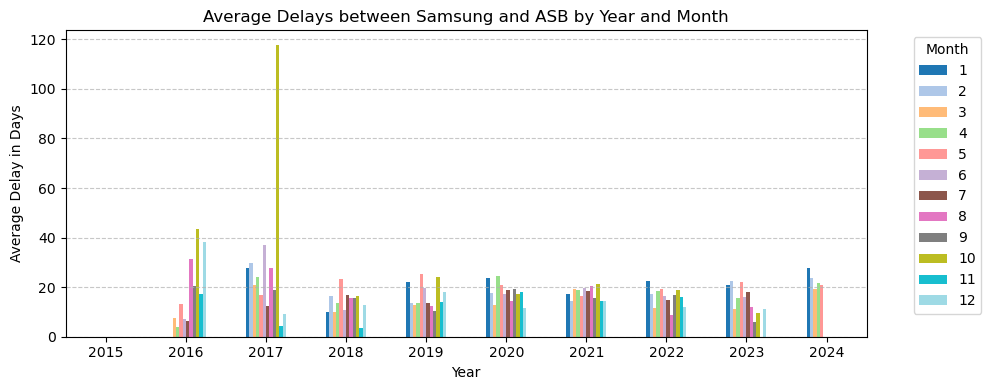

Top 15 CVEs with highest date differences (Samsung):
           CVE  delay_days
CVE-2016-3929         365
CVE-2016-3927         365
CVE-2014-9910         304
CVE-2016-8453         273
CVE-2016-8459         273
CVE-2016-8443         273
CVE-2016-8464         273
CVE-2016-8455         273
CVE-2016-8457         273
CVE-2016-8466         273
CVE-2016-8456         273
CVE-2016-8454         273
CVE-2016-8465         273
CVE-2016-5080         273
CVE-2017-0431         242
Number of CVEs (Samsung) with delays more than 30 days: 1430
Number of CVEs (Samsung) with delays more than 60 days: 294
Number of CVEs (Samsung) with delays more than 90 days: 199
Number of CVEs (Samsung) with delays more than 120 days: 111
Number of CVEs (Samsung) with delays more than 180 days: 52
Number of CVEs (Samsung) with delays more than 365 days: 0



In [15]:
plot_cve_data(intersection_cves_samsung, 'Date_samsung', 'Samsung')


## Huawei

In [16]:
import pandas as pd
from tqdm import tqdm
import csv

huawei_df = pd.read_csv("../2024_Data/huawei/huawei.csv")
asb_bulletins_df = pd.read_csv("../2024_Data/android_security_bulletins.csv")

# Data statistics
print('\nUnique number of Huawei CVEs:', len(set(huawei_df['CVE'])))
print('Unique number of ASOP CVEs:', len(set(asb_bulletins_df['CVE'])))


Unique number of Huawei CVEs: 2859
Unique number of ASOP CVEs: 5138


In [17]:
earliest_date, latest_date, huawei_df, asb_df = process_dates(huawei_df, asb_bulletins_df, 'Huawei')


Huawei CVEs with Earliest Date: 2018-Jan
Huawei CVEs with Latest Date: 2024-May

ASB CVEs with Earliest Date: 2015-Aug
ASB CVEs with Latest Date: 2024-May


In [18]:
# Filter the DataFrame for 'Android Security Bulletins' and get unique CVEs
filtered_df_asb = huawei_df[huawei_df['Patches'] == 'Android Security Bulletins']
asb_specific = set(filtered_df_asb['CVE'])
print('Unique number of ASB-specific CVEs:', len(asb_specific))

# Filter the DataFrame for 'Huawei Patches' and get unique CVEs
filtered_df_huawei = huawei_df[huawei_df['Patches'] == 'Huawei Patches']
huawei_specific = set(filtered_df_huawei['CVE'])
print('Unique number of Huawei-specific CVEs:', len(huawei_specific))

# Find CVEs that are in both 'Android Security Bulletins' and 'Huawei Patches'
common_cves = asb_specific.intersection(huawei_specific)
print('Common CVEs marked as both ASB-specific and Huawei-specific:', len(common_cves))


Unique number of ASB-specific CVEs: 2119
Unique number of Huawei-specific CVEs: 748
Common CVEs marked as both ASB-specific and Huawei-specific: 8


In [19]:
asb = set(asb_df_filtered['CVE'])

# Find Huawei_specific CVEs that are in asb
huawei_cves_asb = asb.intersection(huawei_specific)
huawei_cves_asb = huawei_cves_asb - common_cves
print('Number of Common CVEs:', len(huawei_cves_asb))

# Create DataFrame from huawei_cves_asb
huawei_cves_asb_df = huawei_df[huawei_df['CVE'].isin(huawei_cves_asb)]

# Combine filtered_df_asb and huawei_cves_asb_df
huawei_cves = pd.concat([filtered_df_asb, huawei_cves_asb_df]).drop_duplicates().reset_index(drop=True)


Number of Common CVEs: 3


In [20]:
huawei_cves, asb_df_filtered, huawei_only_cves, cves_not_in_huawei, huawei_only_cves_df, cves_not_in_huawei_df, intersection_cves_huawei = process_df(huawei_cves, asb_df, earliest_date, latest_date, 'huawei')


Unique number of ASB CVEs: 5138
Unique number of ASB CVEs with the same timeframe: 3465

Unique number of huawei CVEs: 2122
Unique number of huawei CVEs that are not in ASB: 758

Unique number of ASB CVEs that are not in huawei CVEs: 2101
Unique number of CVEs that are in both ASB and huawei: 1364


In [79]:
cve_counts_by_year = cves_not_in_huawei_df['year'].value_counts()
print(cve_counts_by_year)
print()

base_severity_by_year = cves_not_in_huawei_df['base_severity'].value_counts()
print(base_severity_by_year)
print()


year
2023    608
2018    516
2022    350
2020    323
2021    283
2019    226
2024    215
Name: count, dtype: int64

base_severity
HIGH        1373
CRITICAL     585
MEDIUM       475
LOW           11
Name: count, dtype: int64



In [23]:
asb_only_common_cwe = cves_not_in_huawei_df['cwe'].value_counts().head(15)

for cwe, count in asb_only_common_cwe.items():
    cwe_info = cves_not_in_huawei_df[cves_not_in_huawei_df['cwe'] == cwe]['cwe_info'].iloc[0]
    print(f"CWE: {cwe:15} | Count: {count:6} | Info: {cwe_info:}")


CWE: CWE-787         | Count:    326 | Info: Out-of-bounds Write
CWE: CWE-119         | Count:    234 | Info: Improper Restriction of Operations within the Bounds of a Memory Buffer
CWE: NVD-CWE-noinfo  | Count:    193 | Info: nan
CWE: CWE-125         | Count:    186 | Info: Out-of-bounds Read
CWE: CWE-416         | Count:    159 | Info: Use After Free
CWE: CWE-120         | Count:    134 | Info: Buffer Copy without Checking Size of Input ('Classic Buffer Overflow')
CWE: CWE-20          | Count:    131 | Info: Improper Input Validation
CWE: CWE-190         | Count:    121 | Info: Integer Overflow or Wraparound
CWE: CWE-129         | Count:     82 | Info: Improper Validation of Array Index
CWE: CWE-862         | Count:     80 | Info: Missing Authorization
CWE: CWE-476         | Count:     79 | Info: NULL Pointer Dereference
CWE: CWE-617         | Count:     75 | Info: Reachable Assertion
CWE: NVD-CWE-Other   | Count:     53 | Info: nan
CWE: CWE-200         | Count:     43 | Info: Exposu

In [24]:
mismatched_cves_huawei, avg_diff_huawei, odd_cves_huawei = process_cve_data(intersection_cves_huawei, 'Date_huawei')


Number of CVEs with varied Release Dates: 779
Average Date Difference: 43.34959349593496

Number of CVEs has Dates before ASB: 41
Unique number of CVEs has Dates before ASB: 33


Average delays (Huawei): 13.850074962518741



<Figure size 1000x600 with 0 Axes>

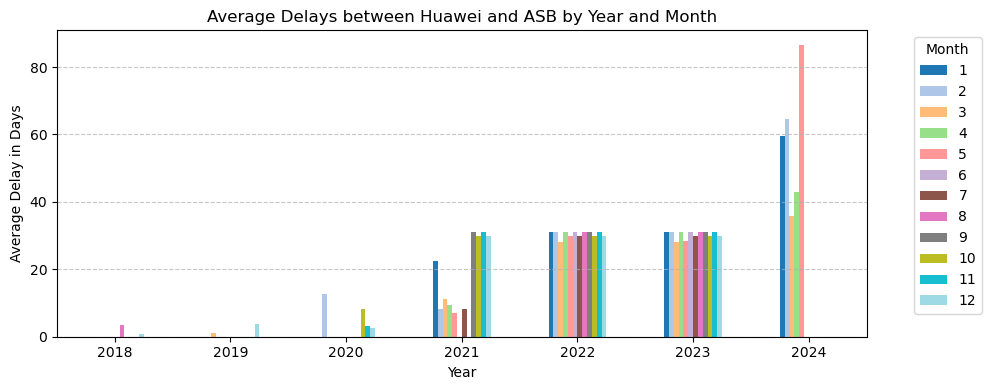

Top 15 CVEs with highest date differences (Huawei):
            CVE  delay_days
CVE-2019-17666         366
CVE-2023-20950         306
CVE-2023-21101         214
CVE-2023-21120         214
CVE-2023-22385         213
CVE-2023-24848         213
CVE-2023-40103         152
 CVE-2020-0114         122
CVE-2023-35674         122
CVE-2023-45866         122
CVE-2023-33040         121
 CVE-2019-2124          91
CVE-2023-43519          90
CVE-2023-43518          90
CVE-2023-45777          62
Number of CVEs (Huawei) with delays more than 30 days: 321
Number of CVEs (Huawei) with delays more than 60 days: 22
Number of CVEs (Huawei) with delays more than 90 days: 12
Number of CVEs (Huawei) with delays more than 120 days: 11
Number of CVEs (Huawei) with delays more than 180 days: 6
Number of CVEs (Huawei) with delays more than 365 days: 1



In [25]:
plot_cve_data(intersection_cves_huawei, 'Date_huawei', 'Huawei')


## Vivo

In [26]:
import pandas as pd
from tqdm import tqdm
import csv

vivo_df = pd.read_csv("../2024_Data/vivo/vivo.csv")
asb_bulletins_df = pd.read_csv("../2024_Data/android_security_bulletins.csv")


In [27]:
earliest_date, latest_date, vivo_df, asb_df = process_dates(vivo_df, asb_bulletins_df, 'Vivo')


Vivo CVEs with Earliest Date: 2019-Jan
Vivo CVEs with Latest Date: 2024-Apr

ASB CVEs with Earliest Date: 2015-Aug
ASB CVEs with Latest Date: 2024-May


In [28]:
vivo_df, asb_df_filtered, vivo_only_cves, cves_not_in_vivo, vivo_only_cves_df, cves_not_in_vivo_df, intersection_cves_vivo = process_df(vivo_df, asb_df, earliest_date, latest_date, 'vivo')


Unique number of ASB CVEs: 5138
Unique number of ASB CVEs with the same timeframe: 2708

Unique number of vivo CVEs: 2492
Unique number of vivo CVEs that are not in ASB: 1

Unique number of ASB CVEs that are not in vivo CVEs: 217
Unique number of CVEs that are in both ASB and vivo: 2491


In [31]:
asb_only_common_cwe = cves_not_in_vivo_df['cwe'].value_counts().head(15)

for cwe, count in asb_only_common_cwe.items():
    cwe_info = cves_not_in_vivo_df[cves_not_in_vivo_df['cwe'] == cwe]['cwe_info'].iloc[0]
    print(f"CWE: {cwe:15} | Count: {count:6} | Info: {cwe_info:}")


CWE: CWE-787         | Count:     58 | Info: Out-of-bounds Write
CWE: NVD-CWE-noinfo  | Count:     43 | Info: nan
CWE: CWE-416         | Count:     30 | Info: Use After Free
CWE: CWE-862         | Count:     28 | Info: Missing Authorization
CWE: CWE-190         | Count:     22 | Info: Integer Overflow or Wraparound
CWE: CWE-362         | Count:     12 | Info: Concurrent Execution using Shared Resource with Improper Synchronization ('Race Condition')
CWE: CWE-125         | Count:     10 | Info: Out-of-bounds Read
CWE: CWE-119         | Count:      9 | Info: Improper Restriction of Operations within the Bounds of a Memory Buffer
CWE: CWE-20          | Count:      7 | Info: Improper Input Validation
CWE: CWE-120         | Count:      5 | Info: Buffer Copy without Checking Size of Input ('Classic Buffer Overflow')
CWE: CWE-276         | Count:      4 | Info: Incorrect Default Permissions
CWE: CWE-122         | Count:      4 | Info: Heap-based Buffer Overflow
CWE: CWE-121         | Count:  

In [32]:
mismatched_cves_vivo, avg_diff_vivo, odd_cves_vivo = process_cve_data(intersection_cves_vivo, 'Date_vivo')


Number of CVEs with varied Release Dates: 47
Average Date Difference: 121.88235294117646

Number of CVEs has Dates before ASB: 30
Unique number of CVEs has Dates before ASB: 19


Average delays (Vivo): 0.0



<Figure size 1000x600 with 0 Axes>

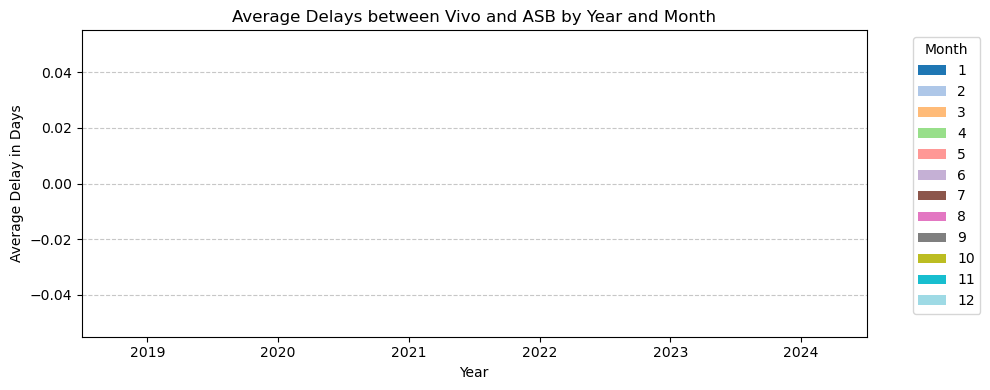

Top 15 CVEs with highest date differences (Vivo):
            CVE  delay_days
CVE-2018-10877           0
CVE-2018-10876           0
 CVE-2018-9594           0
 CVE-2018-9593           0
 CVE-2018-9592           0
 CVE-2018-9591           0
 CVE-2018-9589           0
 CVE-2018-9588           0
 CVE-2018-9587           0
 CVE-2018-9586           0
 CVE-2018-9585           0
 CVE-2018-9584           0
 CVE-2018-9582           0
CVE-2018-11847           0
 CVE-2018-9590           0
Number of CVEs (Vivo) with delays more than 30 days: 0
Number of CVEs (Vivo) with delays more than 60 days: 0
Number of CVEs (Vivo) with delays more than 90 days: 0
Number of CVEs (Vivo) with delays more than 120 days: 0
Number of CVEs (Vivo) with delays more than 180 days: 0
Number of CVEs (Vivo) with delays more than 365 days: 0



In [33]:
plot_cve_data(intersection_cves_vivo, 'Date_vivo', 'Vivo')


## Xiaomi

In [82]:
import pandas as pd
from tqdm import tqdm
import csv

xiaomi_df = pd.read_csv("../2024_Data/xiaomi/xiaomi.csv")
asb_bulletins_df = pd.read_csv("../2024_Data/android_security_bulletins.csv")


In [83]:
xiaomi_df[['Year', 'Month']] = xiaomi_df['SPL'].str.split('-', expand=True)
xiaomi_df['Year'] = '20' + xiaomi_df['Year']
xiaomi_df.head()

,CVE,SPL,SMR,cwe,NVD_descriptions,android_versions,NVD_published,NVD_last_modified,NVD_version,attack_vector,...,privileges_required,user_interaction,confidentiality_impact,integrity_impact,availability_impact,base_score,base_severity,cwe_info,Year,Month
0,CVE-2023-40085,24-Jan,NaN,NaN,In convertSubgraphFromHAL of ShimConverter.cpp...,NaN,2024-02-16T19:15:08.093,2024-02-16T19:26:55.393,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,Jan
1,CVE-2024-0016,24-Jan,NaN,NaN,"In multiple locations, there is a possible out...",NaN,2024-02-16T20:15:47.460,2024-02-16T21:39:50.223,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,Jan
2,CVE-2024-0021,24-Jan,NaN,NaN,In onCreate of NotificationAccessConfirmationA...,NaN,2024-02-16T20:15:47.717,2024-02-16T21:39:50.223,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,Jan
3,CVE-2024-0023,24-Jan,NaN,NaN,In ConvertRGBToPlanarYUV of Codec2BufferUtils....,NaN,2024-02-16T20:15:47.767,2024-02-16T21:39:50.223,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,Jan
4,CVE-2024-0017,24-Jan,NaN,NaN,In shouldUseNoOpLocation of CameraActivity.jav...,NaN,2024-02-16T20:15:47.513,2024-02-16T21:39:50.223,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,Jan


In [84]:
earliest_date, latest_date, xiaomi_df, asb_df = process_dates(xiaomi_df, asb_bulletins_df, 'Xiaomi')


Xiaomi CVEs with Earliest Date: 2020-Jan
Xiaomi CVEs with Latest Date: 2024-Apr

ASB CVEs with Earliest Date: 2015-Aug
ASB CVEs with Latest Date: 2024-May


In [85]:
xiaomi_df, asb_df_filtered, xiaomi_only_cves, cves_not_in_xiaomi, xiaomi_only_cves_df, cves_not_in_xiaomi_df, intersection_cves_xiaomi = process_df(xiaomi_df, asb_df, earliest_date, latest_date, 'xiaomi')


Unique number of ASB CVEs: 5138
Unique number of ASB CVEs with the same timeframe: 2252

Unique number of xiaomi CVEs: 2206
Unique number of xiaomi CVEs that are not in ASB: 10

Unique number of ASB CVEs that are not in xiaomi CVEs: 56
Unique number of CVEs that are in both ASB and xiaomi: 2196


year
2020    62
2023     1
Name: count, dtype: int64

base_severity
HIGH        25
CRITICAL    25
MEDIUM      13
Name: count, dtype: int64



In [40]:

asb_only_common_cwe = cves_not_in_xiaomi_df['cwe'].value_counts().head(15)

for cwe, count in asb_only_common_cwe.items():
    cwe_info = cves_not_in_xiaomi_df[cves_not_in_xiaomi_df['cwe'] == cwe]['cwe_info'].iloc[0]
    print(f"CWE: {cwe:15} | Count: {count:6} | Info: {cwe_info:}")


CWE: CWE-787         | Count:     14 | Info: Out-of-bounds Write
CWE: CWE-125         | Count:     13 | Info: Out-of-bounds Read
CWE: CWE-120         | Count:      7 | Info: Buffer Copy without Checking Size of Input ('Classic Buffer Overflow')
CWE: CWE-416         | Count:      6 | Info: Use After Free
CWE: NVD-CWE-noinfo  | Count:      3 | Info: nan
CWE: CWE-190         | Count:      3 | Info: Integer Overflow or Wraparound
CWE: CWE-119         | Count:      2 | Info: Improper Restriction of Operations within the Bounds of a Memory Buffer
CWE: CWE-476         | Count:      2 | Info: NULL Pointer Dereference
CWE: CWE-203         | Count:      2 | Info: Observable Discrepancy
CWE: CWE-129         | Count:      1 | Info: Improper Validation of Array Index
CWE: CWE-327         | Count:      1 | Info: Use of a Broken or Risky Cryptographic Algorithm
CWE: NVD-CWE-Other   | Count:      1 | Info: nan
CWE: CWE-347         | Count:      1 | Info: Improper Verification of Cryptographic Signatur

In [41]:
mismatched_cves_xiaomi, avg_diff_xiaomi, odd_cves_xiaomi = process_cve_data(intersection_cves_xiaomi, 'Date_xiaomi')


Number of CVEs with varied Release Dates: 1107
Average Date Difference: 54.61290322580645

Number of CVEs has Dates before ASB: 332
Unique number of CVEs has Dates before ASB: 24


Average delays (Xiaomi): 1.0671573137074517



<Figure size 1000x600 with 0 Axes>

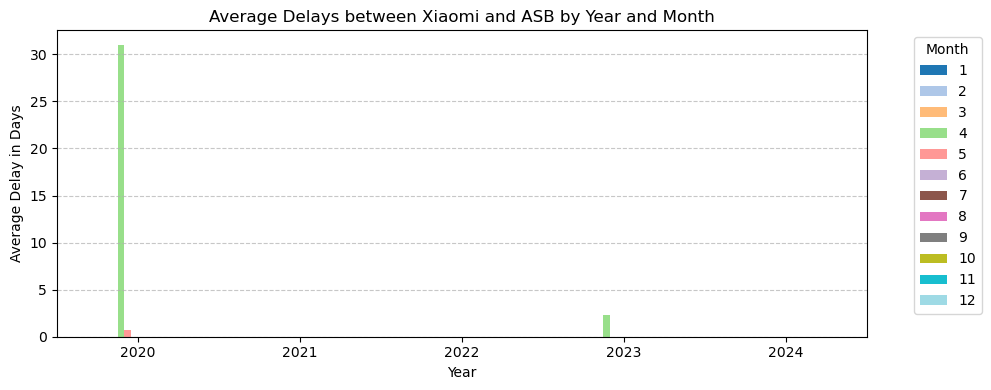

Top 15 CVEs with highest date differences (Xiaomi):
            CVE  delay_days
CVE-2022-20463         151
CVE-2019-14081          31
 CVE-2019-2300          31
CVE-2019-14027          31
CVE-2019-14028          31
CVE-2019-14026          31
CVE-2019-15239          31
 CVE-2020-0037          31
 CVE-2020-0038          31
 CVE-2020-0039          31
CVE-2019-14050          31
CVE-2019-14085          31
 CVE-2020-0031          31
 CVE-2019-2311          31
 CVE-2020-0033          31
Number of CVEs (Xiaomi) with delays more than 30 days: 70
Number of CVEs (Xiaomi) with delays more than 60 days: 1
Number of CVEs (Xiaomi) with delays more than 90 days: 1
Number of CVEs (Xiaomi) with delays more than 120 days: 1
Number of CVEs (Xiaomi) with delays more than 180 days: 0
Number of CVEs (Xiaomi) with delays more than 365 days: 0



In [42]:
plot_cve_data(intersection_cves_xiaomi, 'Date_xiaomi', 'Xiaomi')


## Oppo

In [43]:
import pandas as pd
from tqdm import tqdm
import csv

oppo_df = pd.read_csv("../2024_Data/oppo/oppo.csv")
asb_bulletins_df = pd.read_csv("../2024_Data/android_security_bulletins.csv")


In [44]:
oppo_df[['Year', 'Month']] = oppo_df['SPL'].str.split('-', expand=True)
oppo_df['Year'] = oppo_df['Year'].apply(lambda x: '20' + x if len(x) == 2 else x)


In [45]:
earliest_date, latest_date, oppo_df, asb_df = process_dates(oppo_df, asb_bulletins_df, 'Oppo')


Oppo CVEs with Earliest Date: 2019-Jan
Oppo CVEs with Latest Date: 2024-Apr

ASB CVEs with Earliest Date: 2015-Aug
ASB CVEs with Latest Date: 2024-May


In [46]:
oppo_df, asb_df_filtered, oppo_only_cves, cves_not_in_oppo, oppo_only_cves_df, cves_not_in_oppo_df, intersection_cves_oppo = process_df(oppo_df, asb_df, earliest_date, latest_date, 'oppo')


Unique number of ASB CVEs: 5138
Unique number of ASB CVEs with the same timeframe: 2708

Unique number of oppo CVEs: 2191
Unique number of oppo CVEs that are not in ASB: 84

Unique number of ASB CVEs that are not in oppo CVEs: 601
Unique number of CVEs that are in both ASB and oppo: 2107


In [49]:
mismatched_cves_oppo, avg_diff_oppo, odd_cves_oppo = process_cve_data(intersection_cves_oppo, 'Date_oppo')


Number of CVEs with varied Release Dates: 2618
Average Date Difference: 157.1936170212766

Number of CVEs has Dates before ASB: 1208
Unique number of CVEs has Dates before ASB: 126


Average delays (Oppo): 1.6574307304785894



<Figure size 1000x600 with 0 Axes>

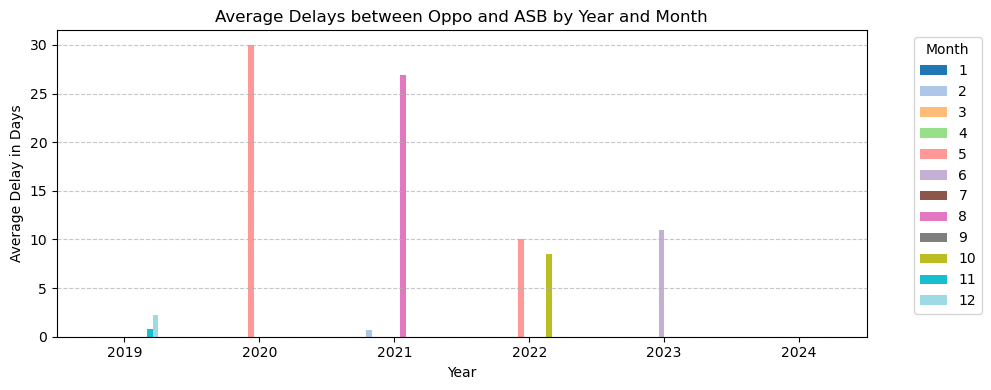

Top 15 CVEs with highest date differences (Oppo):
            CVE  delay_days
CVE-2021-30335         547
 CVE-2020-3633         457
CVE-2021-39628         273
CVE-2021-39621         120
CVE-2021-39627         120
 CVE-2019-2124          91
 CVE-2019-2215          31
CVE-2020-10767          31
 CVE-2020-0072          30
CVE-2019-14070          30
 CVE-2019-8457          30
CVE-2019-14104          30
 CVE-2020-0078          30
 CVE-2020-0079          30
 CVE-2019-2056          30
Number of CVEs (Oppo) with delays more than 30 days: 8
Number of CVEs (Oppo) with delays more than 60 days: 6
Number of CVEs (Oppo) with delays more than 90 days: 6
Number of CVEs (Oppo) with delays more than 120 days: 3
Number of CVEs (Oppo) with delays more than 180 days: 3
Number of CVEs (Oppo) with delays more than 365 days: 2



In [50]:
plot_cve_data(intersection_cves_oppo, 'Date_oppo', 'Oppo')


## LG

In [51]:
import pandas as pd
from tqdm import tqdm
import csv

lg_df = pd.read_csv("../2024_Data/lg/lg.csv")
asb_bulletins_df = pd.read_csv("../2024_Data/android_security_bulletins.csv")


In [52]:
# The website only posts up to Sep 2023.
lg_df = lg_df[~((lg_df['SPL'] == '23-Oct') | (lg_df['SPL'] == '23-Nov') | (lg_df['SPL'] == '23-Dec'))]

lg_df[['Year', 'Month']] = lg_df['SPL'].str.split('-', expand=True)

lg_df['Year'] = lg_df['Year'].astype(str)
lg_df['Year'] = lg_df['Year'].apply(lambda x: '20' + x if len(x) == 2 and x != 'nan' else x)

In [53]:
earliest_date, latest_date, lg_df, asb_df = process_dates(lg_df, asb_bulletins_df, 'LG')


LG CVEs with Earliest Date: 2016-May
LG CVEs with Latest Date: 2023-Sep

ASB CVEs with Earliest Date: 2015-Aug
ASB CVEs with Latest Date: 2024-May


In [54]:
lg_df, asb_df_filtered, lg_only_cves, cves_not_in_lg, lg_only_cves_df, cves_not_in_lg_df, intersection_cves_lg = process_df(lg_df, asb_df, earliest_date, latest_date, 'lg')


Unique number of ASB CVEs: 5138
Unique number of ASB CVEs with the same timeframe: 4595

Unique number of lg CVEs: 4011
Unique number of lg CVEs that are not in ASB: 196

Unique number of ASB CVEs that are not in lg CVEs: 780
Unique number of CVEs that are in both ASB and lg: 3815


In [56]:
cve_counts_by_year = cves_not_in_lg_df['year'].value_counts()
print(cve_counts_by_year)
print()

base_severity_by_year = cves_not_in_lg_df['base_severity'].value_counts()
print(base_severity_by_year)
print()

asb_only_common_cwe = cves_not_in_lg_df['cwe'].value_counts().head(15)

for cwe, count in asb_only_common_cwe.items():
    cwe_info = cves_not_in_lg_df[cves_not_in_lg_df['cwe'] == cwe]['cwe_info'].iloc[0]
    print(f"CWE: {cwe:15} | Count: {count:6} | Info: {cwe_info:}")


year
2018    309
2017    207
2022     85
2020     83
2016     56
2021     46
2019     42
2023     26
Name: count, dtype: int64

base_severity
HIGH        382
CRITICAL    323
MEDIUM      131
LOW           5
Name: count, dtype: int64

CWE: CWE-119         | Count:    149 | Info: Improper Restriction of Operations within the Bounds of a Memory Buffer
CWE: NVD-CWE-noinfo  | Count:     70 | Info: nan
CWE: CWE-20          | Count:     60 | Info: Improper Input Validation
CWE: CWE-200         | Count:     56 | Info: Exposure of Sensitive Information to an Unauthorized Actor
CWE: CWE-787         | Count:     53 | Info: Out-of-bounds Write
CWE: CWE-476         | Count:     51 | Info: NULL Pointer Dereference
CWE: CWE-264         | Count:     50 | Info: Permissions, Privileges, and Access Controls
CWE: CWE-416         | Count:     39 | Info: Use After Free
CWE: CWE-190         | Count:     34 | Info: Integer Overflow or Wraparound
CWE: CWE-125         | Count:     31 | Info: Out-of-bounds Read
C

In [57]:
mismatched_cves_lg, avg_diff_lg, odd_cves_lg = process_cve_data(intersection_cves_lg, 'Date_lg')


Number of CVEs with varied Release Dates: 3626
Average Date Difference: 74.00228180262407

Number of CVEs has Dates before ASB: 120
Unique number of CVEs has Dates before ASB: 67


Average delays (LG): 52.558839190628326



<Figure size 1000x600 with 0 Axes>

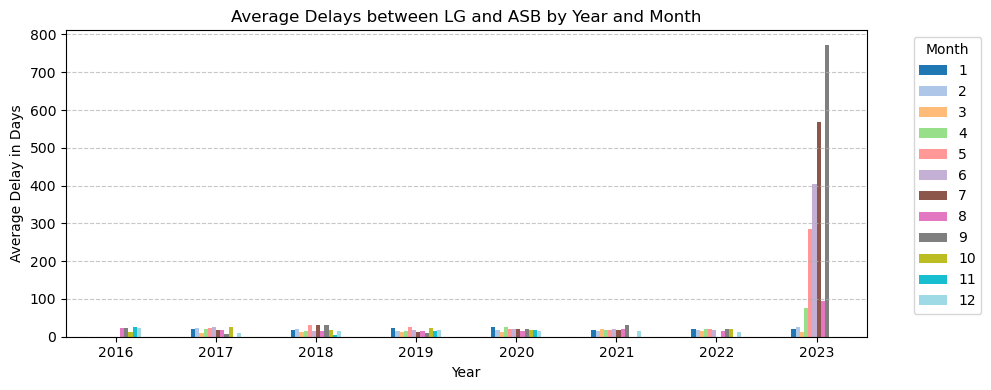

Top 15 CVEs with highest date differences (LG):
            CVE  delay_days
 CVE-2014-9797        2587
 CVE-2016-2438        2556
CVE-2016-10240        2222
CVE-2016-10241        2222
CVE-2016-10278        2222
CVE-2016-10279        2222
 CVE-2018-9417        1857
 CVE-2018-9372        1856
 CVE-2018-9371        1856
 CVE-2018-9370        1856
 CVE-2018-9369        1856
 CVE-2018-9368        1856
 CVE-2018-9367        1856
 CVE-2018-9366        1856
 CVE-2018-9409        1856
Number of CVEs (LG) with delays more than 30 days: 1358
Number of CVEs (LG) with delays more than 60 days: 81
Number of CVEs (LG) with delays more than 90 days: 75
Number of CVEs (LG) with delays more than 120 days: 73
Number of CVEs (LG) with delays more than 180 days: 73
Number of CVEs (LG) with delays more than 365 days: 72



In [58]:
plot_cve_data(intersection_cves_lg, 'Date_lg', 'LG')


## Motorola

In [59]:
import pandas as pd
from tqdm import tqdm
import csv

motorola_df = pd.read_csv("../2024_Data/motorola/motorola.csv")
asb_bulletins_df = pd.read_csv("../2024_Data/android_security_bulletins.csv")



In [60]:
motorola_df[['Year', 'Month']] = motorola_df['SPL'].str.split('-', expand=True)
motorola_df['Year'] = motorola_df['Year'].astype(str)
motorola_df['Year'] = motorola_df['Year'].apply(lambda x: '20' + x if len(x) == 2 and x != 'nan' else x)


In [61]:
earliest_date, latest_date, motorola_df, asb_df = process_dates(motorola_df, asb_bulletins_df, 'Motorola')


Motorola CVEs with Earliest Date: 2020-Jan
Motorola CVEs with Latest Date: 2024-May

ASB CVEs with Earliest Date: 2015-Aug
ASB CVEs with Latest Date: 2024-May


In [62]:
motorola_df, asb_df_filtered, motorola_only_cves, cves_not_in_motorola, motorola_only_cves_df, cves_not_in_motorola_df, intersection_cves_motorola = process_df(motorola_df, asb_df, earliest_date, latest_date, 'motorola')


Unique number of ASB CVEs: 5138
Unique number of ASB CVEs with the same timeframe: 2278

Unique number of motorola CVEs: 2231
Unique number of motorola CVEs that are not in ASB: 47

Unique number of ASB CVEs that are not in motorola CVEs: 94
Unique number of CVEs that are in both ASB and motorola: 2184


In [64]:
cve_counts_by_year = cves_not_in_motorola_df['year'].value_counts()
print(cve_counts_by_year)
print()

base_severity_by_year = cves_not_in_motorola_df['base_severity'].value_counts()
print(base_severity_by_year)
print()

asb_only_common_cwe = cves_not_in_motorola_df['cwe'].value_counts().head(15)

for cwe, count in asb_only_common_cwe.items():
    cwe_info = cves_not_in_motorola_df[cves_not_in_motorola_df['cwe'] == cwe]['cwe_info'].iloc[0]
    print(f"CWE: {cwe:15} | Count: {count:6} | Info: {cwe_info:}")


year
2020    45
2021    34
2024    19
2023     7
2022     3
Name: count, dtype: int64

base_severity
HIGH        62
MEDIUM      21
CRITICAL    16
LOW          2
Name: count, dtype: int64

CWE: CWE-787         | Count:     24 | Info: Out-of-bounds Write
CWE: NVD-CWE-noinfo  | Count:     15 | Info: nan
CWE: CWE-416         | Count:     13 | Info: Use After Free
CWE: CWE-125         | Count:      8 | Info: Out-of-bounds Read
CWE: CWE-120         | Count:      7 | Info: Buffer Copy without Checking Size of Input ('Classic Buffer Overflow')
CWE: CWE-476         | Count:      5 | Info: NULL Pointer Dereference
CWE: CWE-190         | Count:      4 | Info: Integer Overflow or Wraparound
CWE: CWE-20          | Count:      4 | Info: Improper Input Validation
CWE: CWE-440         | Count:      3 | Info: A feature, API, or function does not perform according to its specification. 
CWE: CWE-287         | Count:      2 | Info: Improper Authentication
CWE: CWE-122         | Count:      2 | Info: Heap

In [65]:
mismatched_cves_motorola, avg_diff_motorola, odd_cves_motorola = process_cve_data(intersection_cves_motorola, 'Date_motorola')


Number of CVEs with varied Release Dates: 16111
Average Date Difference: 32.08388042577602

Number of CVEs has Dates before ASB: 422
Unique number of CVEs has Dates before ASB: 120


Average delays (Motorola): 19.54818401937046



<Figure size 1000x600 with 0 Axes>

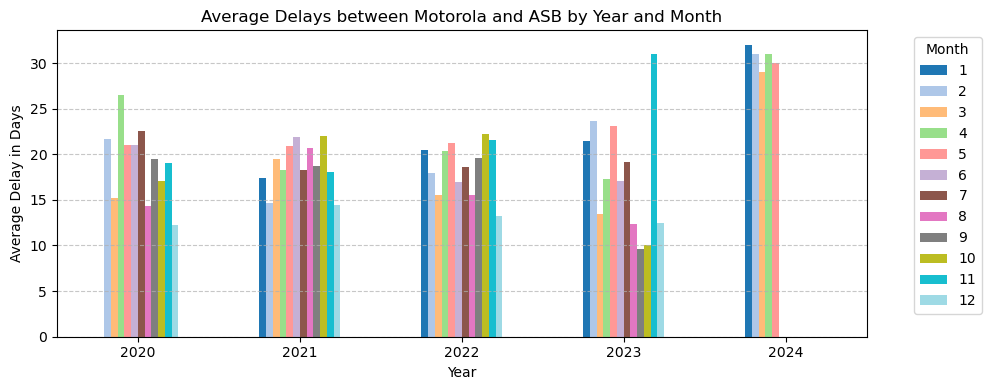

Top 15 CVEs with highest date differences (Motorola):
            CVE  delay_days
CVE-2022-20441          92
 CVE-2023-4863          92
CVE-2019-10585          31
 CVE-2020-0009          31
CVE-2019-10532          31
CVE-2019-10548          31
CVE-2019-10558          31
CVE-2019-10578          31
CVE-2018-20856          31
CVE-2019-10579          31
CVE-2019-10582          31
CVE-2019-10583          31
CVE-2019-15214          31
CVE-2019-10581          31
CVE-2019-10611          31
Number of CVEs (Motorola) with delays more than 30 days: 817
Number of CVEs (Motorola) with delays more than 60 days: 2
Number of CVEs (Motorola) with delays more than 90 days: 2
Number of CVEs (Motorola) with delays more than 120 days: 0
Number of CVEs (Motorola) with delays more than 180 days: 0
Number of CVEs (Motorola) with delays more than 365 days: 0



In [66]:
plot_cve_data(intersection_cves_motorola, 'Date_motorola', 'Motorola')


## Google

In [67]:
import pandas as pd
from tqdm import tqdm
import csv

pixel_df = pd.read_csv("../2024_Data/pixel/pixel.csv")
asb_bulletins_df = pd.read_csv("../2024_Data/android_security_bulletins.csv")


In [68]:
earliest_date, latest_date, pixel_df, asb_df = process_dates(pixel_df, asb_bulletins_df, 'Pixel')


Pixel CVEs with Earliest Date: 2017-Oct
Pixel CVEs with Latest Date: 2024-May

ASB CVEs with Earliest Date: 2015-Aug
ASB CVEs with Latest Date: 2024-May


In [69]:
pixel_df, asb_df_filtered, pixel_only_cves, cves_not_in_pixel, pixel_only_cves_df, cves_not_in_pixel_df, intersection_cves_pixel = process_df(pixel_df, asb_df, earliest_date, latest_date, 'pixel')


Unique number of ASB CVEs: 5138
Unique number of ASB CVEs with the same timeframe: 3555

Unique number of pixel CVEs: 1921
Unique number of pixel CVEs that are not in ASB: 1873

Unique number of ASB CVEs that are not in pixel CVEs: 3507
Unique number of CVEs that are in both ASB and pixel: 48


In [71]:
cve_counts_by_year = cves_not_in_pixel_df['year'].value_counts()
print(cve_counts_by_year)
print()

base_severity_by_year = cves_not_in_pixel_df['base_severity'].value_counts()
print(base_severity_by_year)
print()

asb_only_common_cwe = cves_not_in_pixel_df['cwe'].value_counts().head(15)

for cwe, count in asb_only_common_cwe.items():
    cwe_info = cves_not_in_pixel_df[cves_not_in_pixel_df['cwe'] == cwe]['cwe_info'].iloc[0]
    print(f"CWE: {cwe:15} | Count: {count:6} | Info: {cwe_info:}")


year
2023    823
2018    792
2020    580
2022    544
2021    543
2019    525
2024    261
2017     99
Name: count, dtype: int64

base_severity
HIGH        2305
MEDIUM       897
CRITICAL     749
LOW           34
Name: count, dtype: int64

CWE: CWE-787         | Count:    596 | Info: Out-of-bounds Write
CWE: CWE-125         | Count:    356 | Info: Out-of-bounds Read
CWE: CWE-416         | Count:    320 | Info: Use After Free
CWE: NVD-CWE-noinfo  | Count:    305 | Info: nan
CWE: CWE-119         | Count:    287 | Info: Improper Restriction of Operations within the Bounds of a Memory Buffer
CWE: CWE-20          | Count:    214 | Info: Improper Input Validation
CWE: CWE-190         | Count:    195 | Info: Integer Overflow or Wraparound
CWE: CWE-120         | Count:    158 | Info: Buffer Copy without Checking Size of Input ('Classic Buffer Overflow')
CWE: CWE-862         | Count:    150 | Info: Missing Authorization
CWE: CWE-129         | Count:    102 | Info: Improper Validation of Array Inde

In [72]:
mismatched_cves_pixel, avg_diff_pixel, odd_cves_pixel = process_cve_data(intersection_cves_pixel, 'Date_pixel')


Number of CVEs with varied Release Dates: 166
Average Date Difference: 82.24242424242425

Number of CVEs has Dates before ASB: 133
Unique number of CVEs has Dates before ASB: 8


Average delays (Pixel): 19.8



<Figure size 1000x600 with 0 Axes>

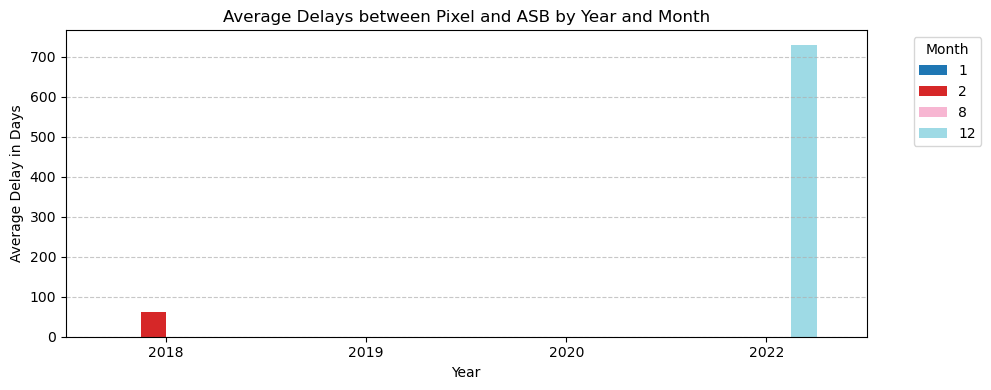

Top 15 CVEs with highest date differences (Pixel):
            CVE  delay_days
 CVE-2020-0465         730
CVE-2017-11043          62
 CVE-2019-9506           0
CVE-2019-10538           0
CVE-2019-10539           0
CVE-2019-10540           0
 CVE-2019-2127           0
 CVE-2019-2267           0
CVE-2019-14034           0
CVE-2019-14024           0
CVE-2019-14023           0
CVE-2019-14010           0
CVE-2019-10585           0
CVE-2019-10602           0
CVE-2019-10548           0
Number of CVEs (Pixel) with delays more than 30 days: 2
Number of CVEs (Pixel) with delays more than 60 days: 2
Number of CVEs (Pixel) with delays more than 90 days: 1
Number of CVEs (Pixel) with delays more than 120 days: 1
Number of CVEs (Pixel) with delays more than 180 days: 1
Number of CVEs (Pixel) with delays more than 365 days: 1



In [73]:
plot_cve_data(intersection_cves_pixel, 'Date_pixel', 'Pixel')


## Comprehensive Analysis

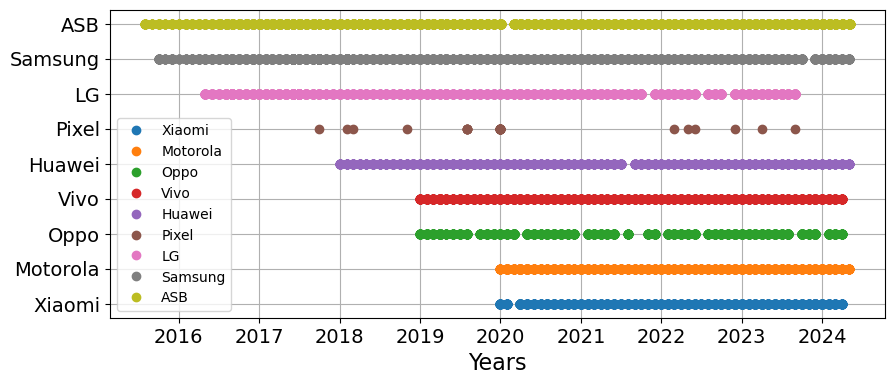

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

asb_bulletins_df['spl_type'] = pd.to_datetime(asb_bulletins_df['spl_type'])
intersection_cves_samsung['Date_samsung'] = pd.to_datetime(intersection_cves_samsung['Date_samsung'])
intersection_cves_huawei['Date_huawei'] = pd.to_datetime(intersection_cves_huawei['Date_huawei'])
intersection_cves_pixel['Date_pixel'] = pd.to_datetime(intersection_cves_pixel['Date_pixel'])
intersection_cves_lg['Date_lg'] = pd.to_datetime(intersection_cves_lg['Date_lg'])
intersection_cves_oppo['Date_oppo'] = pd.to_datetime(intersection_cves_oppo['Date_oppo'])
intersection_cves_vivo['Date_vivo'] = pd.to_datetime(intersection_cves_vivo['Date_vivo'])
intersection_cves_xiaomi['Date_xiaomi'] = pd.to_datetime(intersection_cves_xiaomi['Date_xiaomi'])
intersection_cves_motorola['Date_motorola'] = pd.to_datetime(intersection_cves_motorola['Date_motorola'])

date_columns = {
    'Xiaomi': intersection_cves_xiaomi['Date_xiaomi'],
    'Motorola': intersection_cves_motorola['Date_motorola'],
    'Oppo': intersection_cves_oppo['Date_oppo'],
    'Vivo': intersection_cves_vivo['Date_vivo'],
    'Huawei': intersection_cves_huawei['Date_huawei'],
    'Pixel': intersection_cves_pixel['Date_pixel'],
    'LG': intersection_cves_lg['Date_lg'],
    'Samsung': intersection_cves_samsung['Date_samsung'],
    'ASB': asb_bulletins_df['spl_type']
}

plt.figure(figsize=(10, 4))

for label, dates in date_columns.items():
    plt.plot(dates, [label] * len(dates), 'o', label=label)

plt.xlabel('Years', fontsize=16)
plt.yticks(ticks=range(len(date_columns)), labels=date_columns.keys(), fontsize=14)
plt.xticks(fontsize=14)
# plt.title('Time Frame Covered in Each DataFrame')
plt.legend(fontsize=10)
plt.grid(True)
plt.savefig("../2024_Data/Figures/cve_datasets_timeframe.png", bbox_inches="tight")

plt.show()


In [77]:
import matplotlib.pyplot as plt

def plot_combined_average_delays(intersection_cves_list, vender_names):
    fig, axes = plt.subplots(nrows=len(intersection_cves_list), ncols=1, figsize=(10, 3 * len(intersection_cves_list)))
    
    for idx, (intersection_cves, vender_name) in enumerate(zip(intersection_cves_list, vender_names)):
        # Drop duplicates keeping the one with the least date column
        intersection_cves.sort_values(by=f'Date_{vender_name.lower()}', inplace=True)
        intersection_cves.drop_duplicates(subset='CVE', keep='first', inplace=True)
        
        # Filter rows where date column >= Date_asb
        filtered_cves = intersection_cves[intersection_cves[f'Date_{vender_name.lower()}'] >= intersection_cves['Date_asb']].copy()
        
        filtered_cves['delay_days'] = (filtered_cves[f'Date_{vender_name.lower()}'] - filtered_cves['Date_asb']).dt.days
        average_delay = filtered_cves['delay_days'].mean()
        
        filtered_cves['Year'] = filtered_cves[f'Date_{vender_name.lower()}'].dt.year
        filtered_cves['Month'] = filtered_cves[f'Date_{vender_name.lower()}'].dt.month
        
        # Group by Year and Month, and calculate average delay
        average_delays = filtered_cves.groupby(['Year', 'Month'])['delay_days'].mean().unstack().fillna(0)
        
        # Plotting average delays by year and month
        average_delays.plot(kind='bar', stacked=False, colormap='tab20', ax=axes[idx], legend=False)
        
        axes[idx].set_ylabel(f'{vender_name}')
        axes[idx].set_xlabel('')
        axes[idx].set_title(f'Average Delays ({vender_name})')
        axes[idx].grid(axis='y', linestyle='--', alpha=0.7)

        print(vender_name.capitalize(), "Average Delays:", average_delay.round(2))

        # max_delay = average_delays.max().max()
        # upper_limit = int(max_delay) + 30
        # axes[idx].set_ylim(0, upper_limit)  # Adjust the upper limit (30 here) as needed
    
    axes[-1].set_xlabel('Year', fontsize=12)
    axes[0].legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0) 
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    
    fig.suptitle('Average Delays by Year and Month for Different OEMs', y=0.98)

    fig.subplots_adjust(hspace=0.6)
    plt.savefig("../2024_Data/Figures/average_delays_across_venders.png", bbox_inches="tight")
    
    plt.show()


Samsung Average Delays: 23.21
Huawei Average Delays: 13.85
Lg Average Delays: 52.56
Motorola Average Delays: 19.55
Oppo Average Delays: 1.66
Pixel Average Delays: 19.8
Vivo Average Delays: 0.0
Xiaomi Average Delays: 1.07


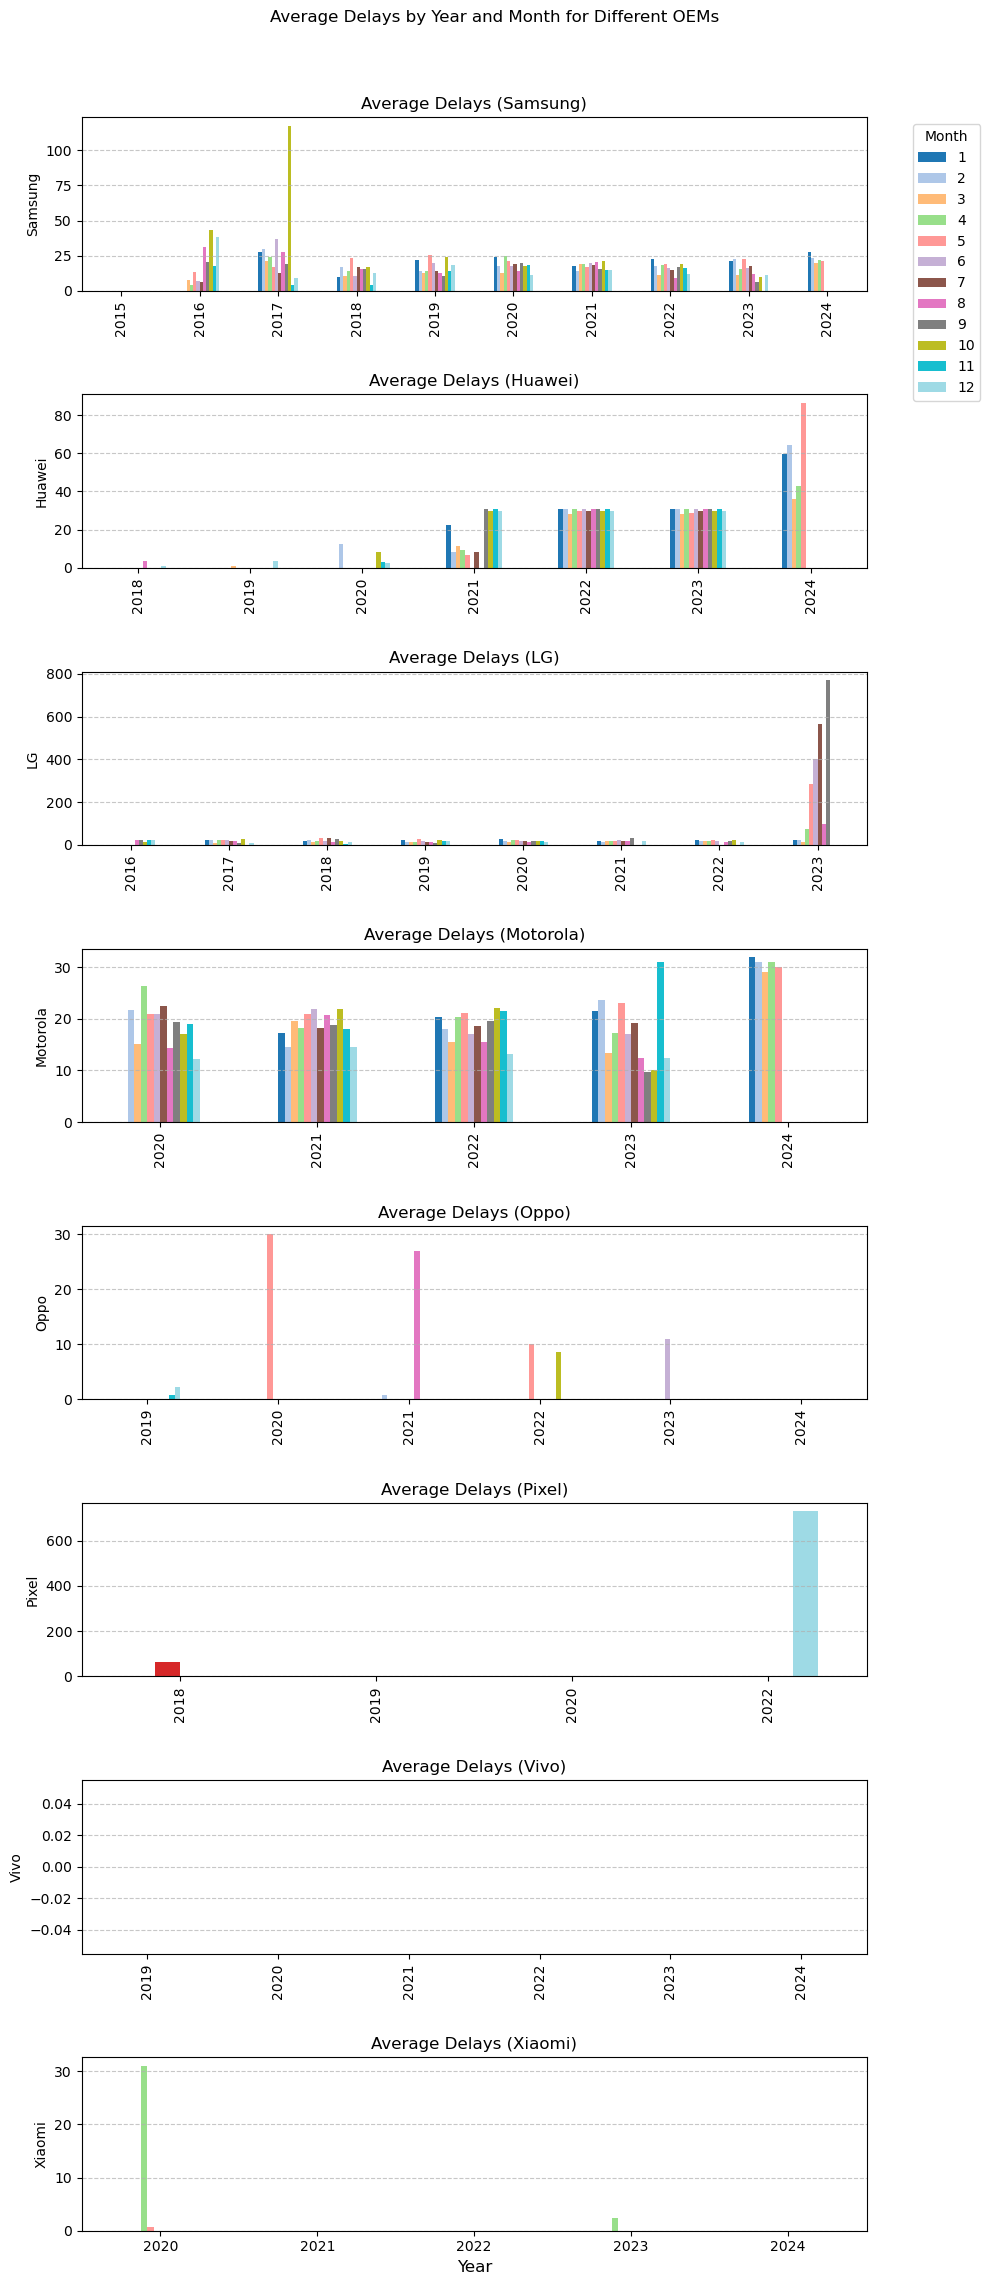

In [78]:
intersection_cves_list = [intersection_cves_samsung, intersection_cves_huawei, intersection_cves_lg,
                          intersection_cves_motorola, intersection_cves_oppo, intersection_cves_pixel,
                          intersection_cves_vivo, intersection_cves_xiaomi]

vender_names = ['Samsung', 'Huawei', 'LG', 'Motorola', 'Oppo', 'Pixel', 'Vivo', 'Xiaomi']

plot_combined_average_delays(intersection_cves_list, vender_names)
